In [2]:
%matplotlib inline

from matplotlib import pyplot as plt
from collections import defaultdict
import json
import numpy as np
import pandas as pd
import re
import sys
import seaborn as sb
from analyze_experiment_in_progress import get_data_from_logs
sb.set()

In [3]:
#bert4rec outperforms everything
#experiment_logs = './results/bert4rec_config_2021_11_04T17_15_31/stdout'

#SALREC-BCE-Great
#experiment_logs = './results/bert4rec_config_2021_11_07T22_26_10/stdout'


#SALREC-Lambdarank 0.157107
#experiment_logs = './results/ml_benchmark20m_2021_11_18T16_38_37/stdout'



#Transformer-Lambdarank 0.1603
#experiment_logs = './results/ml_benchmark20m_2021_11_19T17_43_30/stdout'

#experiment_logs = './results/ml_benchmark20m_2021_11_23T14_39_04/stdout'

#experiment_logs = './results/ml_benchmark20m_2021_11_25T09_41_35/stdout'

#Fast Lambdarank on dekstop
#experiment_logs = './results/ml_benchmark20m_2021_11_27T23_55_22/stdout'


#Fast Lambdarank on dekstop - 40k, bce slightly better
#experiment_logs = './results/ml_benchmark20m_2021_11_28T08_36_11/stdout'


# Learning rate effects:

# Lambdarank
#experiment_logs = "./results/ml_benchmark20m_2021_11_26T10_36_55/stdout"
#BCE
#experiment_logs = "./results/ml_benchmark20m_2021_11_27T11_36_03/stdout"



#Truncation effects: 
#1-20
#experiment_logs = "./results/ml_benchmark20m_2021_11_28T18_14_50/stdout"

#30-120
#experiment_logs = "./results/ml_benchmark20m_2021_11_29T15_12_00/stdout"


#stream -first run: 
#experiment_logs = "./results/steam_benchmark_2021_12_02T16_41_29/stdout"

#steam - num targets
experiment_logs = "./results/steam_benchmark_2021_12_04T12_47_09/stdout"


In [4]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [5]:
data = get_data_from_logs(experiment_logs, 0)

In [6]:
df = pd.DataFrame(data).set_index('model_name')
df

,ndcg@40,precision@10,recall@10,SPS@1,SPS@10,MRR,MAP@10,apr@10,pairwise_cos_sim@10,model_build_time,model_inference_time,model_metadata,num_epochs,metrics_history
model_name,,,,,,,,,,,,,,
svd_recommender-30,0.046807,0.005450,0.05450,0.00600,0.05450,0.024502,0.016039,3949.149199,0.005157,7.176377,123.359369,{'proxy_model': 'filter_seen_recommender'},0,[]
top-recommender,0.047910,0.006050,0.06050,0.00800,0.06050,0.027958,0.020685,3237.901300,0.003333,0.004452,3.224164,{'proxy_model': 'filter_seen_recommender'},0,[]
Transformer-Lambdarank-blocks:3-lr:0.001-ndcg:50-session_len:50-lambda_norm:True-targets:3,0.097355,0.012275,0.12275,0.02025,0.12275,0.057241,0.046037,4752.071308,0.004646,3633.535818,157.983861,"{'epochs_trained': 32, 'best_val_ndcg': 0.10008510202169418, 'val_ndcg_history': [[98.50200152397156, 0.045461662113666534], [196.21031641960144, 0.04914749786257744], [293.98122215270996, 0.05061852186918259], [390.9669246673584, 0.05537416413426399],...",37,"[{'loss': 2.8865, 'ndcg_at_40': 0.0608, 'val_loss': 2.9877, 'val_ndcg_at_40': 0.0455, 'epoch': 1, 'val_ndcg': 0.045461662113666534, 'best_ndcg': 0.045461662113666534, 'steps_since_improved': 0.0, 'total_training_time': 98.50200152397156}, {'loss': 3.35..."
Transformer-BCE-blocks:3-lr:0.001-ndcg:50-session_len:50:-lambda_norm:True-targets:3,0.096572,0.012050,0.12050,0.02150,0.12050,0.056888,0.045248,4744.316015,0.004673,3614.606241,159.905616,"{'epochs_trained': 57, 'best_val_ndcg': 0.10475174337625504, 'val_ndcg_history': [[46.984652280807495, 0.03982779011130333], [94.64289259910583, 0.05002978816628456], [142.52863883972168, 0.051879048347473145], [190.57759165763855, 0.052468959242105484...",75,"[{'loss': 0.0044, 'ndcg_at_40': 0.0574, 'val_loss': 7.1078, 'val_ndcg_at_40': 0.0398, 'epoch': 1, 'val_ndcg': 0.03982779011130333, 'best_ndcg': 0.03982779011130333, 'steps_since_improved': 0.0, 'total_training_time': 46.984652280807495}, {'loss': 0.001..."
Transformer-Lambdarank-blocks:3-lr:0.001-ndcg:50-session_len:50-lambda_norm:True-targets:5,0.096727,0.011825,0.11825,0.02050,0.11825,0.055614,0.043963,4702.614025,0.004566,3687.036084,157.960030,"{'epochs_trained': 29, 'best_val_ndcg': 0.10028131306171417, 'val_ndcg_history': [[98.67168045043945, 0.04643572121858597], [197.49124336242676, 0.05340263620018959], [297.1401491165161, 0.05558694154024124], [396.98373103141785, 0.06028440222144127], ...",37,"[{'loss': 3.3918, 'ndcg_at_40': 0.0693, 'val_loss': 3.7883, 'val_ndcg_at_40': 0.0464, 'epoch': 1, 'val_ndcg': 0.04643572121858597, 'best_ndcg': 0.04643572121858597, 'steps_since_improved': 0.0, 'total_training_time': 98.67168045043945}, {'loss': 3.5395..."
Transformer-BCE-blocks:3-lr:0.001-ndcg:50-session_len:50:-lambda_norm:True-targets:5,0.105843,0.013100,0.13100,0.02625,0.13100,0.064224,0.052400,4574.505134,0.004401,3609.097490,159.249006,"{'epochs_trained': 72, 'best_val_ndcg': 0.10896703600883484, 'val_ndcg_history': [[48.449158668518066, 0.04248063266277313], [97.66690683364868, 0.04307455196976662], [148.06732821464539, 0.04862886294722557], [197.01383066177368, 0.051760412752628326]...",73,"[{'loss': 0.0043, 'ndcg_at_40': 0.0636, 'val_loss': 7.3378, 'val_ndcg_at_40': 0.0425, 'epoch': 1, 'val_ndcg': 0.04248063266277313, 'best_ndcg': 0.04248063266277313, 'steps_since_improved': 0.0, 'total_training_time': 48.449158668518066}, {'loss': 0.001..."
Transformer-Lambdarank-blocks:3-lr:0.001-ndcg:50-session_len:50-lambda_norm:True-targets:1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30,"[{'loss': 0.2763, 'ndcg_at_40': 0.0181, 'val_loss': 0.3968, 'val_ndcg_at_40': 0.0125, 'epoch': 1, 'val_ndcg': 0.012519720941781998, 'best_ndcg': 0.012519720941781998, 'steps_since_improved': 0.0, 'total_training_time': 95.60484409332275}, {'loss': 0.46..."


0 dict_keys([0])
1 dict_keys([0, 1])


<Figure size 1152x648 with 0 Axes>

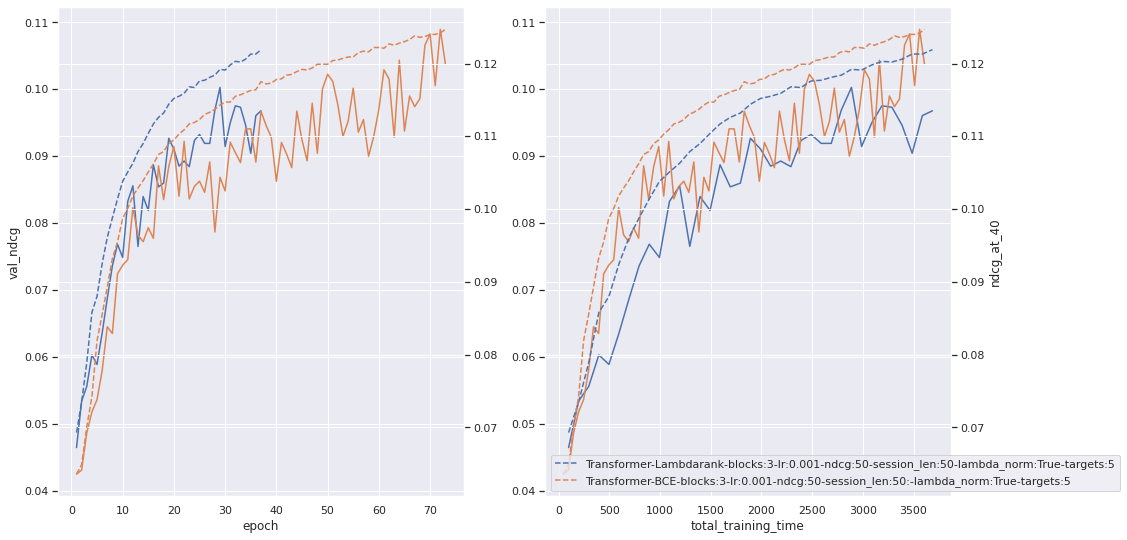

In [15]:
moving_average_steps=1
max_points = 30000


def get_metric(metric_history, metric_name):
    result = []
    for item in metric_history:
        try:
            result.append(item[metric_name])
        except:
            print(item)
    return result

plt.figure(figsize=(16, 9))

axises = ['epoch', 'total_training_time']

fig, ax = plt.subplots(1, len(axises))
fig.set_figheight(9)
fig.set_figwidth(16)

interesting_models = ['Transformer-Lambdarank-blocks:3-lr:0.001-ndcg:50-session_len:50-lambda_norm:True-targets:5',
                      'Transformer-BCE-blocks:3-lr:0.001-ndcg:50-session_len:50:-lambda_norm:True-targets:5']
second_metrics = {}

for recommender in data:
    if recommender['model_name'] not in interesting_models:
        continue
    if len(recommender['metrics_history']) > 0:
        history = recommender['metrics_history']
        metric_name = 'val_ndcg'
        second_metric_name = 'ndcg_at_40'
        metric = moving_average(get_metric(history, metric_name), moving_average_steps)[:max_points]
        if second_metric_name != None:
            second_metric = moving_average(get_metric(history, second_metric_name), moving_average_steps)[:max_points]
        #success = get_metric(history, 'Success_at_4')
        #val_success = moving_average(get_metric(history, 'val_Success_at_4'), 5)
        
        #plt.plot(val_success, label=recommender['model_name'] + "val_sps")
        #plt.plot(success, label=recommender['model_name'] + "sps")
        for axis_num in range(len(axises)):
            axis_name = axises[axis_num]
            axis = get_metric(history, axis_name)[moving_average_steps - 1:][:max_points]
            ax[axis_num].plot(axis, metric,label=recommender['model_name'])
            
            ax[axis_num].set_xlabel(axis_name)
            if axis_num == 0:
                ax[axis_num].set_ylabel(metric_name)
            
            if (second_metric_name != None):
                if axis_num not in second_metrics:
                    second_metrics[axis_num] = ax[axis_num].twinx()
                    print(axis_num, second_metrics.keys())
                ax2 = second_metrics[axis_num]
                if axis_num == 1:
                    ax2.set_ylabel(second_metric_name)
                ax2.plot(axis, second_metric, '--', label=recommender['model_name'],)

            
        #plt.plot(ndcg, label=recommender['model_name'] + "ndcg")
        #plt.plot(val_success, label=recommender['model_name'] + "_val_sps")
plt.legend()


In [16]:
len(metric), len(metric) - np.argmax(metric) - 1

(73, 1)

In [136]:
max(metric)

0.12517809867858887